# IREC Roll and Active Drag Controls Algorithm 
## 1.1 Import some useful packages  

In [26]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from sympy import Matrix

## 1.2 Create an LQR Solver for an optimal K matrix
**We need to create** a function that solves the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [27]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

## 1.3 Create Functions to convert from imperial to metric units

In [28]:
def ft_to_m(measurement):
    return (measurement / 3.2808) 

## 2 Derive equations of motion 
## 2.1 Define some symbolic variables (we could sub any values into them later! Easy)
### Example: if x, y, and z are the variabels that we want to turn them into symbolics: do this:
$$
x, y, z = sym.symbols('x,y,z')
$$

## Define the states:
### Reminder: 
$$
\dot{x} = Ax + Bu \\
y = Cx
$$
### A is the matrix that relates the states to the change of the states 
### B is the matrix that relates the inputs to the change of the states

In [29]:
# defining components of position 
h, y, z = sym.symbols('h, y, z')

# defining roll, pitch and yaw
psi, theta, phi  = sym.symbols('psi, theta, phi')

# defining the components of the linear velocity 
u, v, w = sym.symbols('u, v, w')

# defining compoenents for angular velocity 
wx, wy, wz = sym.symbols('wx, wy, wz')

## Define inputs of the system (u)

In [30]:
l1, l2 = sym.symbols('l1, l2')

## Define some constants that we are interested in/that we already have! 
g: acceleration of gravity, W_f: width of the flaps, Ixx: angular acceleration of the rocket body, Sref_a: aerodynamic reference area of the rocket body, rho: density of air, m: dry mass of the rocket, D: diameter of rocket 

Cd_a: coefficient of drag of the rocket airframe, Cd_f: coefficient of drag of the flaps, Cl_a: coefficient of lift of the rocket airframe, Cl_f: coefficient of lift of the flaps 

In [31]:
# defining the physical parameters on the rocket 
g, W_f, Ixx, Sref_a, rho, m, D = sym.symbols('g, W_f, Ixx, Sref_a, rho, m, D')
# defining the coefficients 
Cd_a, Cd_f, Cl_a, Cl_f = sym.symbols('Cd_a, Cd_f, Cl_a, Cl_f')

## 2.2 Create equations of motion! 

### Velocity 
$$\dot{h}$$

In [32]:
hdot = u
hdot

u

### Acceleration 
$$\ddot{h} = \frac{-0.5 \cdot \rho \cdot v^2 \cdot Cd_a \cdot S_{refA} - \rho \cdot v^2 \cdot Cd_f \cdot w(l_1 + l_2)-mg}{m}$$

In [33]:
hddot = -((rho * u**2 * Sref_a * Cd_a) / (2*m)) - ((rho * u**2 * Cd_f * W_f * (l1+l2))/m) - g
hddot

-Cd_a*Sref_a*rho*u**2/(2*m) - Cd_f*W_f*rho*u**2*(l1 + l2)/m - g

### Angular Acceleration 
$$\dot{\omega} = \frac{\rho v^2 \cdot Cl_f \cdot W_f \cdot (l1D + l1^2 - l2D - l2^2)}{2I_{xx}}$$

In [34]:
omegadot = (rho * u**2 * Cl_f * W_f * (l1*D + l1**2 - l2*D - l2**2)) / (2*Ixx)
omegadot

Cl_f*W_f*rho*u**2*(D*l1 - D*l2 + l1**2 - l2**2)/(2*Ixx)

### Create a systems of equation complier that outputs a column matrix with size 3 by 1
$$f_{sym}$$
use this following code to create a column matrix of the three EOMs
$$f_{sym} = sym.Matrix.vstack$$

In [35]:
f_sym = Matrix.vstack(Matrix([[hdot],[hddot],[omegadot]]))
f_sym

Matrix([
[                                                              u],
[-Cd_a*Sref_a*rho*u**2/(2*m) - Cd_f*W_f*rho*u**2*(l1 + l2)/m - g],
[        Cl_f*W_f*rho*u**2*(D*l1 - D*l2 + l1**2 - l2**2)/(2*Ixx)]])

## 3 Derive the state-space model 
$$\dot{x} = Ax + Bu$$
### Time to derive the A and B matrices!! But first, we need to define the equilibrium points, remember we need to sub them into the symbolic A, B, and C matrices to obtain a CONSTANT matrices. 

## 3.1
### Think about equilibrium. Where is a good equilibrium position for THIS launch? The official definition of the equilibrium point is: 
An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ - along with constant parameters $p_\text{eq}$ - for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

### We need to put down two sets of equilibrium values:
$$x_{eq}$$
and 
$$u_{eq}$$
First is the equilibrium for the state x: 
 equilibrium state for us is when the rocket is at apogee where $$\dot{h} = v = 0 m/s$$
$$\ddot{h} = a = -9.8 \frac{m}{s^2}$$
$$h = 3000$$

### Let's go ahead and create two lists: list "s", list "i", and list "p", they contain respectively, the symbolics of the states, and input as defined in Section 1, and some constants

### Defining x

In [36]:
s = [h, hdot, wx]

### Defining u

In [37]:
i = [l1, l2]

### Defining a set of parameters/constants in that appear in the f_sym equation

In [38]:
p = [Cd_f, Sref_a,Cd_a,rho, W_f, m, g, Cl_f, Ixx, D]

### Time to create a function that allows you to sub in the equilibrium values of the states into those symbolic values to obtain a constant state after taking the Jacobian of the matrix
$$
f = sym.lambdify(x + u, f_{sym})
$$

In [39]:
f = sym.lambdify(s + i + p, f_sym)

### Now we put in the constants that we know, allll the constants
### Good thing is we already pre-defined those constants symbolically, so remember to use those 'specific' values!

In [40]:
# Mass of the rocket
m = 50 #kg

# moment of inertia
Ixx = 0.5*m*0.1524**2

# acceleration of gravity
g = 9.81 #m/s^2

#  lift coefficient of the rocket 
Cl_a = 0.063

# lift coefficient of the flaps 
Cl_f = 2*np.pi*np.sin(45)

# drag coefficient of the rocket 
Cd_a = 0.58

# drag coefficient of the flaps
Cd_f = 2*np.pi*np.sin(45)

# Width of the flaps 
W_f = 0.0254 # meters

# Diameter of the rocket 
D = 0.1524 # meters

# reference area of the rocket 
Sref_a = np.pi*(D/2)**2

# Density of air 
rho = 1.225 # kg/m^3


### Time to use the same 's' and 'u' matrices we have defined above and sub in our desired equilibrium values, lots of zerossss

### We need to test sub in those values into the f using
$$
f(*s,*i,*p)
$$
print them out to see if that's what you wanted 

In [41]:
#Define Equilibrium Values for the States and Inputs
#* FIXME
h_e = ft_to_m(3000)
hdot_e = 1
omega_e = 0
l1_e = 0
l2_e = 0
#Create lists of equilibrium states, inputs, parameters
s_eq = [h_e,hdot_e,omega_e]
i_eq = [l1_e,l2_e]
p_eq = [Cd_f,Sref_a,Cd_a,rho,W_f,m,g,Cl_f,Ixx,D]

#* Sub in the values using the f() function
f(*s_eq,*i_eq,*p_eq)

array([[ 1.        ],
       [-9.81012961],
       [ 0.        ]])

## 3.2 Computing A and B 
### We are finally at where we want, using jacobian, and sub in values to find a constant A and B matrix!

We want to find

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\text{and}\qquad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

First, we compute each Jacobian (i.e., each matrix of partial derivatives) in symbolic form.

### Define A_sym and B_sym, the drill is very similar to how we defined the f_sym and f. You will see the similarity. The code goes like this 
$$
A_{sym} = f_{sym}.jacobian(s) \\
B_{sym} = f_{sym}.jacobian(i)
$$

In [42]:
A_sym = f_sym.jacobian(s)
B_sym = f_sym.jacobian(i)

### Again, remember the lambdify function? 
### It allows us to substitute values into those pre-defined symbolic expressions. At this moment, the A_sym and B_sym are still symbolic after the jacobian. 

In [43]:
A_num = sym.lambdify(s + i + p, A_sym)
B_num = sym.lambdify(s + i + p, B_sym)

### Time to sub in the equilibrium values! Refer back to how we sub in the values into the 'f' function in the last section to write out this section

In [44]:
A = A_num(*s_eq, *i_eq, *p_eq)
B = B_num(*s_eq, *i_eq, *p_eq)

### Show the A and B matrices in a nice looking way using this: 

In [45]:
A_str = np.array2string(A,
                        formatter={'float_kind': lambda x: f'{x:5.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)
print(f'A = {A_str}')

A = [[ 0.00  1.00  0.00]
     [ 0.00 -0.00  0.00]
     [ 0.00  0.00  0.00]]


In [46]:
B_str = np.array2string(B,
                        formatter={'float_kind': lambda x: f'{x:10.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'B = {B_str}')

B = [[      0.00       0.00]
     [     -0.00      -0.00]
     [      0.02      -0.02]]


The state-space system is described by

$$ \dot{x} = Ax + Bu $$

where

$$ x = s - s_\text{eq} $$

and

$$ u = i - i_\text{eq}. $$

## 4 Design a controller (Reference tracking and LQR design)

### 4.1 Controller Design 
For your controller, this is the state-feedback form:

$$u = - K (x - x_\text{des})$$

where the gain matrix $K$ is chosen by solving an infinite-horizon LQR problem (e.g., with the helper function `lqr`) and where

$$x_\text{des} = \begin{bmatrix} o_{h, \text{des}} \\ o_{\dot{h}, \text{des}} \\ o_{\ddot{h}, \text{des}} \end{bmatrix}.$$

Remember that the LQR problem is defined by the choice of weights $Q$ and $R$. Both must be square matrices. Both $Q$ and $R$ are almost always chosen to be diagonal. Remember that $Q$ penalizes non-zero states (i.e., non-zero values of $x$) and that $R$ penalizes non-zero inputs (i.e., non-zero values of $u$). If you want smaller states, increase $Q$. If you want smaller inputs, increase $R$.


Hint: Use np.diag() to create those two diagonal matrices 

In [47]:
## Designing a Q matrix 
Q = np.diag([2.86, 1, 1])

## Designing a R matrix
R = np.diag([1, 1])


### Calculate the K matrix using the lqr function we have defined! 

In [48]:
K = lqr(A,B,Q,R)

### Show a nicely formatted K matrix: 

In [49]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[-1.196 -18.933  0.707]
     [-1.196 -18.933 -0.707]]


## Controller Testing



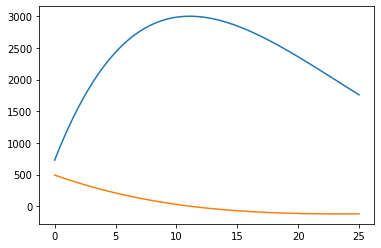

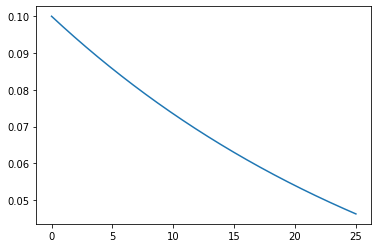

3000.0126427390614


In [50]:
#State Space Equation for Controller
#xdot = Ax + Bu, u = -Kx
#xdot = (A - BK)x

from scipy import integrate

tspan = np.linspace(0,25,num=1000) #from 0 -> 25 seconds
xinit = [727.65,491.29,0.1] #altitude, velcity at burnout and random starting roll rate

def state_space_func(t,x,Amat,Bmat,Kmat):
    xdot = (Amat - Bmat@Kmat) @ x
    return xdot

sol = integrate.solve_ivp(state_space_func,[tspan[0], tspan[-1]], xinit, t_eval=tspan, rtol = 1e-5,args=(A,B,K))

plt.plot(sol.t,sol.y[0]) #alt
plt.plot(sol.t,sol.y[1]) #vertical velocity
plt.show()
plt.plot(sol.t,sol.y[2]) #roll rate
plt.show()
print(max(sol.y[0]))